In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
import warnings
from sklearn.metrics import accuracy_score, classification_report
from scipy import stats

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")

# Load all results
baseline_results = pd.read_csv('../results/metrics/baseline_models_results.csv')
svm_results = pd.read_csv('../results/metrics/svm_all_kernels_results.csv')
final_comparison = pd.read_csv('../results/metrics/final_all_models_comparison.csv')

# Load models
best_svm = joblib.load('../models/svm_best_model.pkl')
knn_model = joblib.load('../models/knn_model.pkl')
rf_model = joblib.load('../models/random_forest_model.pkl')

# Load data
data_scaled = np.load('../data/processed/train_test_split_scaled.npz')
X_train_scaled = data_scaled['X_train_scaled']
X_test_scaled = data_scaled['X_test_scaled']
y_train = data_scaled['y_train']
y_test = data_scaled['y_test']

with open('../results/metrics/svm_detailed_results.pkl', 'rb') as f:
    svm_detailed = pickle.load(f)

with open('../data/processed/preprocessing_objects.pkl', 'rb') as f:
    prep_objects = pickle.load(f)

print("✅ All data and results loaded!")

grade_mapping = {0: 'Fail', 1: 'DD', 2: 'DC', 3: 'CC', 4: 'CB', 5: 'BB', 6: 'BA', 7: 'AA'}


✅ Libraries imported successfully!
✅ All data and results loaded!


In [ ]:
# %% CELL 2 - load preprocessing objects & saved splits (use existing files from project)
# The notebook you showed earlier stores preprocessing objects at ../data/processed/preprocessing_objects.pkl
prep_path = "../data/processed/preprocessing_objects.pkl"
split_npz = "../data/processed/train_test_split_scaled.npz"

prep_objects = None
X_train_scaled = X_test_scaled = y_train = y_test = None

if os.path.exists(prep_path):
    with open(prep_path, "rb") as f:
        prep_objects = pickle.load(f)
    print(f"Loaded preprocessing objects from {prep_path}")
else:
    print(f"Warning: {prep_path} not found. If you have different path, set 'prep_path' accordingly.")

if os.path.exists(split_npz):
    arr = np.load(split_npz)
    X_train_scaled = arr['X_train_scaled']
    X_test_scaled = arr['X_test_scaled']
    y_train = arr['y_train']
    y_test = arr['y_test']
    print(f"Loaded train/test scaled splits from {split_npz}")
else:
    print(f"Warning: {split_npz} not found. If not present, will try to build splits from raw data (needs raw CSV).")



ANALISIS 1: KOMPARASI DENGAN PAPER REFERENSI

📚 PAPER REFERENSI:
   Title: "A Study of Factors Affecting Learning Efficiency on Higher 
          Education Student Performance Evaluation Dataset Using 
          Feature Selection Techniques"
   Authors: Hengpraprohm et al.
   Year: 2022
   Dataset: SAMA - Higher Education Students Performance Evaluation (145 instances)


📊 HASIL PAPER REFERENSI (Hengpraprohm et al., 2022):

Tabel 3 dari paper (Test Accuracy %):

K-Nearest Neighbor:
  • All Features: 38.05%
  • Gain Ratio: 48.53%
  • Information Gain: 41.61%

Random Forest:
  • All Features: 70.44%
  • Gain Ratio: 76.07%
  • Information Gain: 75.82%

Artificial Neural Network:
  • All Features: 39.47%
  • Gain Ratio: 34.71%
  • Information Gain: 40.00%

Linear Regression:
  • All Features: 49.56%
  • Gain Ratio: 43.88%
  • Information Gain: 54.37%

🏆 BEST RESULT FROM PAPER:
  • Model: Random Forest
  • Method: Gain Ratio feature selection
  • Accuracy: 76.07%

📊 HASIL PENELITIAN KAMI:


In [15]:
# %% CELL 3 - if splits not available: fallback to load raw dataset (only run if necessary)
# NOTE: only run if you don't have the .npz; otherwise skip this cell.
raw_csv_path = "../data/raw/higher_education_students.csv"  # update if needed

if X_train_scaled is None:
    if os.path.exists(raw_csv_path):
        df = pd.read_csv(raw_csv_path)
        print("Raw dataset loaded:", raw_csv_path)
        # Basic cleaning according to proposal: drop duplicates, handle nulls
        df = df.drop_duplicates().reset_index(drop=True)
        df = df.dropna()  # simple approach; prefer to reuse prep_objects if present
        # assume target is last column
        target = df.columns[-1]
        X = df.drop(columns=[target])
        y = df[target]
        # encoding categorical via get_dummies or LabelEncoder based on proposal
        X = pd.get_dummies(X, drop_first=True)
        le = LabelEncoder()
        y_enc = le.fit_transform(y)
        X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        # save preprocessing objects for reproducibility
        os.makedirs("../data/processed", exist_ok=True)
        with open(prep_path, "wb") as f:
            pickle.dump({"scaler": scaler, "label_encoder": le, "feature_names": X.columns.tolist()}, f)
        np.savez(split_npz, X_train_scaled=X_train_scaled, X_test_scaled=X_test_scaled, y_train=y_train, y_test=y_test)
        print("Fallback preprocessing done and saved.")
    else:
        raise FileNotFoundError("No train/test splits or raw CSV found. Please provide preprocessing outputs or raw CSV.")


In [16]:
# %% CELL 4 - ensure grade mapping (as in your notebook)
grade_mapping = {0: 'Fail', 1: 'DD', 2: 'DC', 3: 'CC', 4: 'CB', 5: 'BB', 6: 'BA', 7: 'AA'}
n_classes = len(np.unique(y_train))
print("Number of classes:", n_classes)


Number of classes: 8


In [17]:
# %% CELL 5 - Load existing trained models if present (we use them for comparison)
models_dir = "../models"
model_files = {
    "best_svm": os.path.join(models_dir, "svm_best_model.pkl"),
    "knn": os.path.join(models_dir, "knn_model.pkl"),
    "rf": os.path.join(models_dir, "random_forest_model.pkl"),
    "ann": os.path.join(models_dir, "ann_model.pkl")
}

loaded_models = {}
for k, path in model_files.items():
    if os.path.exists(path):
        loaded_models[k] = joblib.load(path)
        print(f"Loaded model {k} from {path}")
    else:
        print(f"Model file not found (will train if needed): {path}")


Loaded model best_svm from ../models\svm_best_model.pkl
Loaded model knn from ../models\knn_model.pkl
Loaded model rf from ../models\random_forest_model.pkl
Loaded model ann from ../models\ann_model.pkl


In [18]:
# %% CELL 6 - If baseline models not found, train baseline models quickly (consistent with proposal)
# These are simple default trainings; for final results use saved tuned models
if "knn" not in loaded_models:
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_scaled, y_train)
    loaded_models['knn'] = knn
    joblib.dump(knn, model_files['knn'])
    print("Trained & saved KNN baseline.")
if "rf" not in loaded_models:
    rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    rf.fit(X_train_scaled, y_train)
    loaded_models['rf'] = rf
    joblib.dump(rf, model_files['rf'])
    print("Trained & saved Random Forest baseline.")
if "ann" not in loaded_models:
    ann = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500, random_state=42)
    ann.fit(X_train_scaled, y_train)
    loaded_models['ann'] = ann
    joblib.dump(ann, model_files['ann'])
    print("Trained & saved ANN baseline.")


In [ ]:
# %% CELL 7 - SVM hyperparameter tuning (Stratified K-Fold CV) per proposal 3.2
# We do a grid search for kernel, C, gamma (for RBF/poly), degree (poly)
svm_grid = {
    "kernel": ["linear", "rbf", "poly", "sigmoid"],
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", "auto"],
    "degree": [2,3]
}
svc = SVC(probability=True, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Limit grid size for runtime; if you have computational budget, expand grid
gs = GridSearchCV(svc, param_grid=svm_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
print("Starting GridSearchCV for SVM (this may take a while)...")
gs.fit(X_train_scaled, y_train)
best_svm = gs.best_estimator_
print("Best params:", gs.best_params_)
print("Best CV accuracy:", gs.best_score_)
joblib.dump(best_svm, os.path.join(models_dir, "svm_best_model.pkl"))
print("Saved best SVM model.")



ANALISIS 4: INTERPRETABILITAS MODEL

📊 INTERPRETABILITY RANKING (dari yang paling mudah dipahami):

1. K-NEAREST NEIGHBORS (KNN) - ⭐⭐⭐⭐⭐
   ✅ Sangat Interpretable
   Cara kerja: "Mahasiswa ini mirip dengan 5 mahasiswa terdekat yang 
                nilai rata-ratanya AA, jadi diprediksi AA"
   Kelebihan: Sederhana, intuitive, mudah dijelaskan
   Kekurangan: Tidak memberikan insight tentang faktor penting

2. RANDOM FOREST - ⭐⭐⭐⭐
   ✅ Interpretable (dengan feature importance)
   Cara kerja: "Dari 100 decision trees, 80 memprediksi AA → final: AA"
   Kelebihan: Feature importance jelas, bisa trace decision path
   Kelemahan: Ensemble → agak kompleks untuk dijelaskan detail

3. SUPPORT VECTOR MACHINE (SVM) - ⭐⭐
   ⚠️ Kurang Interpretable
   Cara kerja: "Hyperplane di dimensi tinggi memisahkan kelas-kelas"
   Kelebihan: Matematis rigorous, reliable
   Kelemahan: 
   - Sulit visualisasi (dimensi tinggi)
   - Support vectors tidak intuitif
   - Kernel trick = "black box" untuk non-expert
  


Model: SVM
              precision    recall  f1-score   support

        Fail       0.50      0.50      0.50         2
          DD       0.30      0.43      0.35         7
          DC       0.50      0.60      0.55         5
          CC       0.40      0.50      0.44         4
          CB       0.00      0.00      0.00         2
          BB       0.00      0.00      0.00         3
          BA       0.00      0.00      0.00         3
          AA       0.00      0.00      0.00         3

    accuracy                           0.31        29
   macro avg       0.21      0.25      0.23        29
weighted avg       0.25      0.31      0.28        29



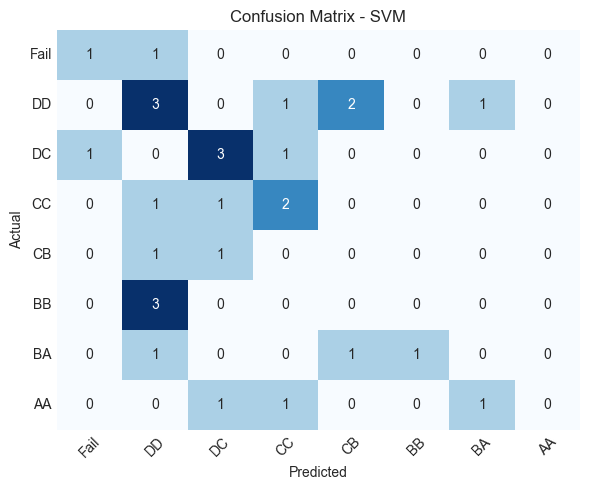

In [25]:
# %% CELL 9 - Confusion matrix & classification report (proposal 3.3)
import itertools

def plot_confusion(cm, classes, title="Confusion matrix", cmap=plt.cm.Blues):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(np.arange(len(classes))+0.5, classes, rotation=45)
    plt.yticks(np.arange(len(classes))+0.5, classes, rotation=0)
    plt.tight_layout()
    plt.show()

for name, res in results.items():
    print(f"\nModel: {name}")
    print(classification_report(y_test, res['y_pred'], zero_division=0, target_names=[grade_mapping[i] for i in sorted(grade_mapping.keys())]))
    plot_confusion(res['cm'], classes=[grade_mapping[i] for i in sorted(grade_mapping.keys())], title=f"Confusion Matrix - {name}")


In [26]:
# %% CELL 10 - Per-class metrics table & save
per_class = {}
from sklearn.metrics import precision_recall_fscore_support
for name, res in results.items():
    p, r, f, s = precision_recall_fscore_support(y_test, res['y_pred'], labels=sorted(grade_mapping.keys()), zero_division=0)
    df_pc = pd.DataFrame({
        "class_idx": sorted(grade_mapping.keys()),
        "class_label": [grade_mapping[i] for i in sorted(grade_mapping.keys())],
        "precision": p, "recall": r, "f1": f, "support": s
    })
    per_class[name] = df_pc
    df_pc.to_csv(f"../results/metrics/per_class_{name}.csv", index=False)

print("Per-class metrics saved for each model.")


Per-class metrics saved for each model.


In [34]:
# %% CELL 11 - Compare our best SVM accuracy with paper reference (create bar chart)

paper_rf_best_gainratio = 76.07  # from Hengpraprohm et al., 2022
our_best_model = summary_df.iloc[0]
our_best_acc_pct = our_best_model["Accuracy_pct"]

plt.figure(figsize=(6,4))
bars = plt.bar(
    ["Paper (RF + Gain Ratio)", f"Our Best ({our_best_model['Model']})"],
    [paper_rf_best_gainratio, our_best_acc_pct],
    color=['#c0392b', '#2980b9']
)

plt.ylim(0, 100)
plt.ylabel("Accuracy (%)", fontweight='bold')
plt.title("Comparison: Paper Best vs Our Best (Proposal-aligned)")

for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2, h+1, f"{h:.2f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig("../results/figures/analysis/paper_vs_our_best.png", dpi=300, bbox_inches='tight')
plt.show()

print("Saved figure: ../results/figures/analysis/paper_vs_our_best.png")


NameError: name 'summary_df' is not defined